# Evolution of cooperation

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

### Previous code

From the Chapter 11 notebook, we will reuse `Simulation` and `Instrument`.

In [2]:
class Simulation:
    
    def __init__(self, fit_land, agents):
        """Create the simulation:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [4]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
        
    def plot(self, **options):
        plt.plot(self.metrics, **options)

In [5]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    label = 'Mean fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

### PD Agent

The genome of a Prisoner's Dilemma-playing agent is a map from the previous choices of the opponent to the agent's next choice.

In [53]:
class Agent:
    
    keys = [(None, None),
            (None, 'C'),
            (None, 'D'),
            ('C', 'C'),
            ('C', 'D'),
            ('D', 'C'),
            ('D', 'D')]
    
    def __init__(self, values, fitness=np.nan):
        """Initialize the agent.
        
        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness
        
    def reset(self):
        """Reset variables before a sequence of games.
        """
        self.hist = [None, None]
        self.score = 0
        
    def past_responses(self, num=2):
        """Select the given number of most recent responses.
        
        num: integer number of responses
        
        returns: sequence of 'C' and 'D'
        """
        return tuple(self.hist[-num:])
    
    def respond(self, other):
        """Choose a response based on the opponent's recent responses.
        
        other: Agent
        
        returns: 'C' or 'D'
        """
        key = other.past_responses()
        resp = self.responses[key]
        return resp
        
    def append(self, resp, pay):
        """Update based on the last response and payoff.
        
        resp: 'C' or 'D'
        pay: number
        """
        self.hist.append(resp)
        self.score += pay
        
    def copy(self, prob_mutate=0.01):
        """Make a copy of this agent.
        """
        if np.random.random() > prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values, self.fitness)
    
    def mutate(self):
        """Makes a copy of this agent's values, with one mutation.
        
        returns: sequence of 'C' and 'D'
        """
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

Here's the genome for "always cooperate"

In [7]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

And for "always defect"

In [8]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None, None): 'D',
 (None, 'C'): 'D',
 (None, 'D'): 'D',
 ('C', 'C'): 'D',
 ('C', 'D'): 'D',
 ('D', 'C'): 'D',
 ('D', 'D'): 'D'}

And for "tit for tat"

In [9]:
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

The `copy` method has some probability of generating a mutation (in this example, `values` is initially a string; after mutation, it's a NumPy array of letters).

In [10]:
np.random.seed(17)
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
['D', 'C', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'C', 'D', 'D', 'D', 'D']


In [11]:
np.sum([all_d.copy().values != all_d.values for i in range(1000)])

57

### The Tournament

`Tournament` encapsulates the rules for the tournament.

In [12]:
class Tournament:
    
    payoffs = {('C', 'C'): (3, 3),
               ('C', 'D'): (0, 5),
               ('D', 'C'): (5, 0),
               ('D', 'D'): (1, 1)}
    
    num_rounds = 6

    def play(self, agent1, agent2):
        """Play a sequence of iterated PD rounds.
        
        agent1: Agent
        agent2: Agent

        returns: tuple of agent1's score, agent2's score 
        """
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
            
        return agent1.score, agent2.score
                
    def melee(self, agents, randomize=True):
        """Play each agent against two others.
        
        Assigns the average score from the two games to agent.fitness
        
        agents: sequence of Agents
        randomize: boolean, whether to shuffle the agents
        """
        if randomize:
            agents = np.random.permutation(agents)
            
        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n
        
        totals = np.zeros(n)
        
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
            
        for i in i_row:
            agents[i].fitness = totals[i] / self.num_rounds / 2

We can test `Tournament` with a few known scenarios.

In [13]:
tour = Tournament()
tour.play(all_d, all_c)

(30, 0)

In [14]:
tour.play(all_d, tft)

(10, 5)

In [15]:
tour.play(tft, all_c)

(18, 18)

And then test `melee` with a list of three agents.

In [16]:
agents = [all_c, all_d, tft]
agents

In [17]:
tour.melee(agents)

In this population, "always defect" does best.

In [18]:
for agent in agents:
    print(agent.values, agent.fitness)

CCCCCCC 1.5
DDDDDDD 3.3333333333333335
CCDCDCD 1.9166666666666667


### Probability of survival

We need a function to map from points per round (0 to 5) to probability of survival (0 to 1).  I'll use a logistic curve.

In [19]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [20]:
def prob_survive(scores):
    """Probability of survival, based on fitness.
    
    scores: sequence of scores, 0-60
    
    returns: probability
    """
    return logistic(scores, A=0.7, B=1.5, M=2.5, K=0.9)

In [20]:
scores = np.linspace(0, 5)
probs = prob_survive(scores)
plt.plot(scores, probs)
decorate(xlabel='Score', ylabel='Probability of survival')

### The simulator

The biggest change in the simulator is in `step`, which runs `melee` to determine the fitness of each agent, and `prob_survive` to map from fitness to probability of surviving.

In [21]:
class PDSimulation(Simulation):
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        Simulation.step(self)
        
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: fitness of each agent
        
        returns: indices of the chosen ones
        """
        ps = prob_survive(fits)
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

We might want to start with random agents.

In [22]:
def make_random_agents(n):
    """Make agents with random genotype.
    
    n: number of agents
    
    returns: sequence of agents
    """
    agents = [Agent(np.random.choice(['C', 'D'], size=7)) 
              for _ in range(n)]
    return agents

Or with all identical agents.

In [23]:
def make_identical_agents(n, values):
    """Make agents with the given genotype.
    
    n: number of agents
    values: sequence of 'C' and 'D'
    
    returns: sequence of agents
    """
    agents = [Agent(values) for _ in range(n)]
    return agents

Here are the instruments to compute various metrics.

`Niceness` is the average number of `C` across the genotypes in the population.

In [24]:
class Niceness(Instrument):
    """Fraction of cooperation in all genotypes."""
    label = 'Niceness'
        
    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

`Opening` is the fraction of agents that cooperate in the first round.

In [25]:
class Opening(Instrument):
    """Fraction of agents that cooperate on the first round."""
    label = 'Opening'
        
    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

`Retaliating` is the difference between (1) the fraction of agents that defect after the opponent defects and (2) the fraction of agents that defect after the opponent cooperates. 

In [28]:
class Retaliating(Instrument):
    """Tendency to defect after opponent defects."""
    label = 'Retaliating'
        
    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)

Forgiving is the difference between the number of agents that cooperate after DC minus the number that cooperate after CD.

In [29]:
class Forgiving(Instrument):
    """Tendency to cooperate if opponent cooperates after defecting."""
    label = 'Forgiving'
        
    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)

Here's another metric intended to measure forgiveness.

In [30]:
class Forgiving2(Instrument):
    """Ability to cooperate after the first two rounds."""
    label = 'Forgiving2'
        
    def update(self, sim):
        after_two = np.array([agent.values[3:] for agent in sim.agents])
        metric = np.mean(np.any(after_two=='C', axis=1))
        self.metrics.append(metric)

### Results

Here's a simulation that starts with 100 defectors and runs 5000 timesteps.

In [31]:
tour = Tournament()

agents = make_identical_agents(100, list('DDDDDDD'))
sim = PDSimulation(tour, agents)

sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Retaliating())
sim.add_instrument(Forgiving())

Run the simulation.  If you get a warning about `Mean of empty slice`, that's ok.

In [32]:
np.random.seed(17)
sim.run(5000)

/home/neophile/Install/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


And let's look at some results.

In [35]:
def plot_result(index, **options):
    """Plots the results of the indicated instrument.
    
    index: integer
    """
    sim.plot(index, **options)
    instrument = sim.instruments[index]
    print(np.mean(instrument.metrics[1000:]))
    decorate(xlabel='Time steps', 
                     ylabel=instrument.label)

Initially, mean fitness is 1, because that's the number of points each defector gets per round when facing another defector.

After a few hundred steps, mean fitness climbs to a steady state near 2.5, although it oscillates around this point substantially.

In a world of all cooperators, mean fitness would be 3, so this steady state is hardly utopia, but it's not that far off.

2.5006129717570604
Saving figure to file figs/chap12-1


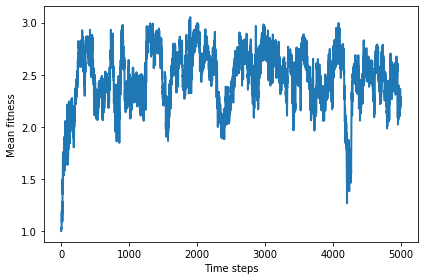

In [36]:
plot_result(0, color='C0')
savefig('figs/chap12-1')

To average number of C's, across all agents and all locations in the genome, is generally more than half, with a long range mean above 0.6.

0.6453083157781982


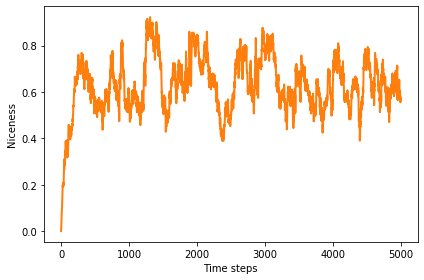

In [37]:
plot_result(1, color='C1')

The results are similar for the opening move: the fraction of agents who start out cooperating is generally more than half, with a long-range mean above 0.6.  This fraction varies widely in time.

0.67127968007998


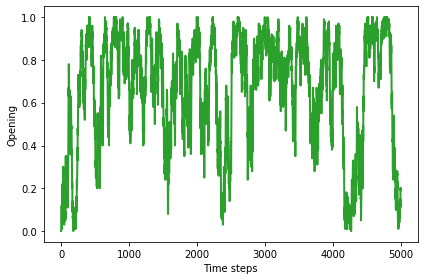

In [38]:
plot_result(2, color='C2')

0.6453083157781982
0.67127968007998
Saving figure to file figs/chap12-2


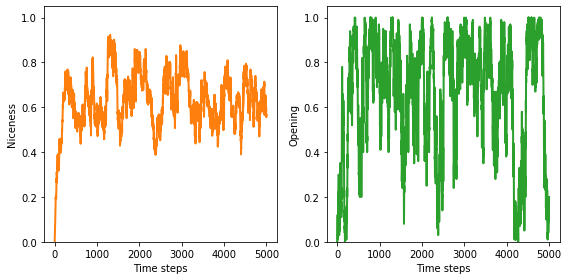

In [39]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plot_result(1, color='C1')
decorate(ylim=[0, 1.05])

plt.subplot(1,2,2)
plot_result(2, color='C2')
decorate(ylim=[0, 1.05])

savefig('figs/chap12-2')

There might be a weak inclination toward retaliation, with slightly more defections after the opponent defects.

0.07278680329917521


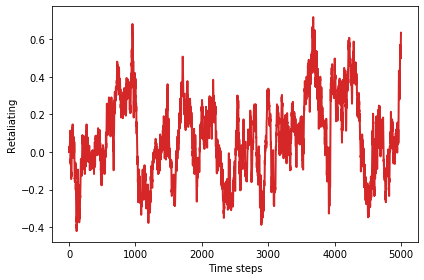

In [40]:
plot_result(3, color='C3')

All of the strategies are forgiving in the sense that they have a short memory, so most of them are capable of cooperating at some point after an opponent has defected.  But there is no evidence that they are specifically more likely to forgive a defection from two rounds ago, compared to a defection in the previous round.

-0.009162709322669325


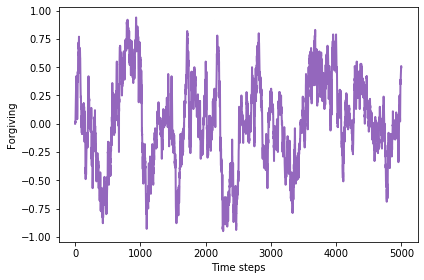

In [41]:
plot_result(4, color='C4')

The following cells explore the composition of the final population.  But because the distribution of agents varies so much over time, the details of a single timestep might not mean much.

Here are the final genomes:

In [42]:
for agent in sim.agents:
    print(agent.values)

['D', 'C', 'D', 'C', 'C', 'C', 'C']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['D', 'D', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'C']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'D', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'D', 'C', 'C', 'C']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['C', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'C', 'C', 'D', 'C', 'D']
['D', 'C', 'C', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'C', 'C', 'D']
['D', 'C', 'D', 'C', 'D', 'C', 'D']
['C', 'C', 'D', 'C', 'D', 'C', 'C']
['D', 'C', 'D', 'C', 'D', 'C

And here are the most common genomes:

In [43]:
from pandas import Series

responses = [''.join(agent.values) for agent in sim.agents]
Series(responses).value_counts()

DCDCCCD    20
DCDCDCD    20
DCDCCCC    10
CCDCCCD    10
DCCCDCD     9
CCDCDCC     7
DCDCDCC     7
DDDCDCD     6
DCDDCCC     3
CCDDCCD     2
DDCCCDC     2
DDCCCCD     1
DDDCDCC     1
DCCCDCC     1
CCCCDCD     1
dtype: int64

**Exercise:** The simulation in this notebook depends on a number of conditions and parameters I chose arbitrarily.  As an exercise, I encourage you to explore other conditions to see what effect they have on the results.  Here are some suggestions:

1.  Vary the initial conditions: instead of starting with all defectors, see what happens if you start with all cooperators, all TFT, or random agents.

2.  In `Tournament.melee`, I shuffle the agents at the beginning of each time step, so each agent plays against two randomly-chosen agents.  What happens if you don't shuffle?  In that case, each agent would play against the same neighbors repeatedly.  That might make it easier for a minority strategy to invade a majority, by taking advantage of locality.

3.  Since each agent only plays against two other agents, the outcome of each round is highly variable: an agent that would do well against most other agents might get unlucky during any given round, or the other way around.  What happens if you increase the number of opponents each agent plays against during each round?  Or what if an agent's fitness at the end of each step is the average of its current score and its fitness at the end of the previous round?

4.  The function I chose for `prob_survival` varies from 0.7 to 0.9, so the least fit agent, with `p=0.7`, lives for `3.33` timesteps, on average, and the most fit agent lives for `10` timesteps.  What happens if you make `prob_survival` more or less "aggressive".

5.  I chose `num_rounds=6` so that each element of the genome has roughly the same impact on the outcome of a match.  But that is substantially shorter than what Alexrod used in his tournaments.  What happens if you increase `num_rounds`?  Note: if you explore the effect of this parameter, you might also want to create an instrument to measure the niceness of the last 4 elements of the genome, which will be under more selective pressure as `num_rounds` increases.

6.  My implementation has differential survival but just random reproduction.  What happens if you add differential reproduction?



/home/neophile/Install/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


4.162427032130856
0.8085646445531475


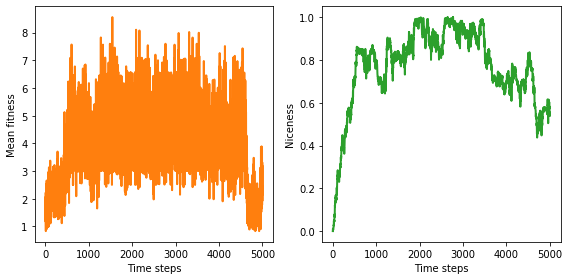

In [54]:
class Tournament2:
    
    payoffs = {('C', 'C'): (3, 3),
               ('C', 'D'): (0, 5),
               ('D', 'C'): (5, 0),
               ('D', 'D'): (1, 1)}
    
    num_rounds = 6

    def play(self, agent1, agent2):
        """Play a sequence of iterated PD rounds.
        
        agent1: Agent
        agent2: Agent

        returns: tuple of agent1's score, agent2's score 
        """
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
            
        return agent1.score, agent2.score
                
    def melee(self, agents, randomize=True, melee_size=6):
        """Play each agent against two others.
        
        Assigns the average score from the two games to agent.fitness
        
        agents: sequence of Agents
        randomize: boolean, whether to shuffle the agents
        """
        if randomize:
            agents = np.random.permutation(agents)
            
        n = len(agents)
        
        lead_players = np.arange(n)
        follower_players = [
            ((lead_players+i)%n) for i in range(1, melee_size)
        ]
        
        totals = np.zeros(n)
        
        for lead, followers in zip(lead_players, follower_players):
            for follower in followers:
                score_l, score_f = self.play(agents[lead], agents[follower])
                totals[lead] += score_l
                totals[follower] += score_f
            
            
        for i in lead_players:
            agents[i].fitness = totals[i] / self.num_rounds / melee_size

class PDSimulation2(Simulation):
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        Simulation.step(self)
        
    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.
        
        fits: fitness of each agent
        
        returns: indices of the chosen ones
        """
        ps = logistic(fits, A=0.7, B=1.5, M=2.5, K=0.97)
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
    
tour = Tournament2()

agents = make_identical_agents(100, list('DDDDDDD'))
sim = PDSimulation2(tour, agents)

sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Retaliating())
sim.add_instrument(Forgiving())

np.random.seed(17)
sim.run(5000)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plot_result(0, color='C1')

plt.subplot(1,2,2)
plot_result(1, color='C2')

plt.show()

# 2.5 
# With melee sizes of 6 instead of 3, and also K=0.97 (fewer random deaths), mean fitness is much higher (3.8 insead of 2.5), even though niceness is about the same or a bit lower (0.61 instead of 0.66).

**Exercise:**  In these simulations, the population never converges to a state where a majority share the same, presumably optimal, genotype.  There are two possible explanations for this outcome: one is that there is no optimal strategy, because whenever the population is dominated by a majority genotype, that condition creates an opportunity for a minority to invade; the other possibility is that the mutation rate is high enough to maintain a diversity of genotypes even if the majority is non-optimal.  To distinguish between these explanations, try lowering the mutation rate to see what happens.  Alternatively, start with a random population and run without mutation until only one genotype survives.  Or run with mutation until the system reaches something like a steady state; then turn off mutation and run until there is only one surviving genotype.  What are the characteristics of the genotypes that prevail in these conditions? 

In [44]:
# With mutation probability 0.01 instead of 0.05, mean fitness seems similar or a bit higher (4.1 instead of 3.6), but mean nice